# Part 3 - K Nearest Neighbors (KNN)

#### By Aziz Presswala

In [1]:
#importing libraries
import numpy as np
import pandas as pd
import seaborn as sn
import sqlite3
import matplotlib.pyplot as plt
from tqdm import tqdm
from prettytable import PrettyTable

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import cross_validation
from gensim.models import Word2Vec

C:\Users\Aziz\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Aziz\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# Using the CleanedText column saved in final.sqlite db
con = sqlite3.connect('final.sqlite')
filtered_data = pd.read_sql_query("SELECT * FROM Reviews", con)
filtered_data.shape

(364171, 12)

In [3]:
#randomly selecting 60k points from the dataset
#tried with 100k points but showed memory error
df=filtered_data.sample(60000)

In [4]:
#sort the dataset by timestamp
df = df.sort_values('Time')
#splitting the dataset into train(70%) & test(30%)
train_data = df[0:42000]
test_data = df[42000:60000]
#saving the train and test datasets in csv files
train_data.to_csv('train.csv')
test_data.to_csv('test.csv')

In [6]:
#selecting 10k points to implement kd-tree
train_data_kd = df[0:7000]
test_data_kd = df[7000:10000]

## BoW

### Simple Cross Validation(brute)

In [5]:
#applying fit transform on train datasset
count_vect = CountVectorizer(max_features=2000, min_df=50)
x_train_bow = count_vect.fit_transform(train_data['CleanedText'].values)
x_train_bow.shape

(42000, 2000)

In [6]:
#applying transform on test dataset
x_test_bow = count_vect.transform(test_data['CleanedText'].values)
x_test_bow.shape

(18000, 2000)

In [7]:
y_train_bow = train_data['Score']
y_test_bow = test_data['Score']

In [8]:
# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(x_train_bow, y_train_bow, test_size=0.3)

f1_scores=[]
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

for i in neighbors:
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i, algorithm='brute')

    # fitting the model on crossvalidation train
    knn.fit(X_tr, y_tr)

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv)
    
    #evaluate CV f1-score
    f1 = f1_score(y_cv, pred, pos_label='positive', average='binary')
    
    #printing f1-score of positive class for each k
    print('\nCV f1-score for k = %d is %f' % (i, f1))
    f1_scores.append(f1)
    

# determining optimal k
optimal_k = neighbors[f1_scores.index(max(f1_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

knn = KNeighborsClassifier(optimal_k)
knn.fit(X_tr,y_tr)
pred = knn.predict(x_test_bow)

#determining the Test f1 score for optimal k
f1 = f1_score(y_test_bow, pred, pos_label='positive', average='binary')
print('\n****Test f1-score for k = %d is %f****' % (optimal_k,f1))

#determining the Test accuracy for optimal k
acc = accuracy_score(y_test_bow, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = %d is %f%%****' % (optimal_k,acc))


CV f1-score for k = 1 is 0.900763

CV f1-score for k = 3 is 0.917187

CV f1-score for k = 5 is 0.920492

CV f1-score for k = 7 is 0.920743

CV f1-score for k = 9 is 0.921038

CV f1-score for k = 11 is 0.920895

CV f1-score for k = 13 is 0.920606

CV f1-score for k = 15 is 0.920694

CV f1-score for k = 17 is 0.920800

CV f1-score for k = 19 is 0.920813

CV f1-score for k = 21 is 0.920860

CV f1-score for k = 23 is 0.920774

CV f1-score for k = 25 is 0.920715

CV f1-score for k = 27 is 0.920597

CV f1-score for k = 29 is 0.920518

The optimal number of neighbors is 9.

****Test f1-score for k = 9 is 0.904950****

****Test accuracy for k = 9 is 82.750000%****


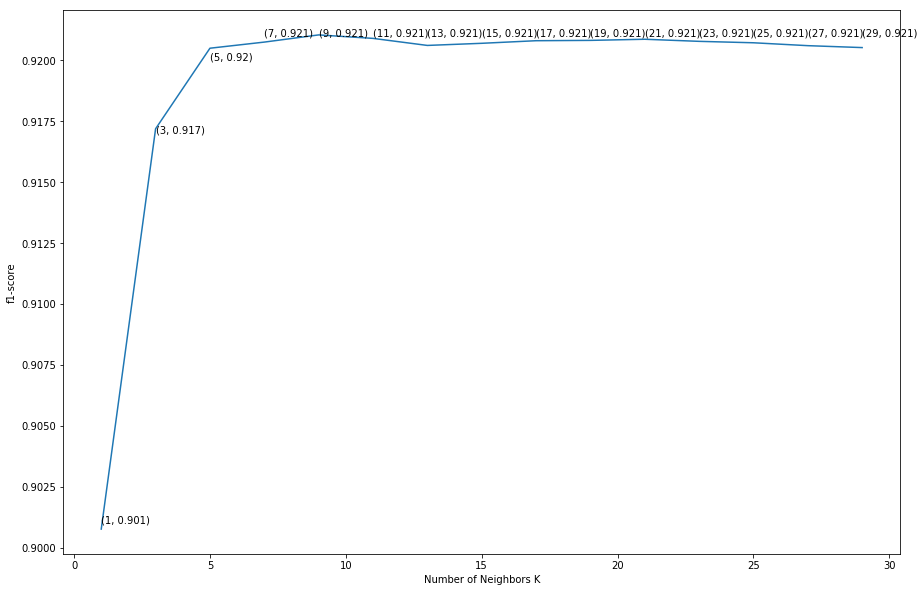

The f1-score for each k value is :  [0.90076 0.91719 0.92049 0.92074 0.92104 0.9209  0.92061 0.92069 0.9208
 0.92081 0.92086 0.92077 0.92072 0.9206  0.92052]


In [21]:
# plot f1-score vs k 
plt.figure(figsize=(15,10))
plt.plot(neighbors, f1_scores)
for xy in zip(neighbors, np.round(f1_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('f1-score')
plt.show()

print("The f1-score for each k value is : ", np.round(f1_scores,5))

### Simple Cross Validation (kd-tree)

In [7]:
#applying fit transform on train datasset
count_vect = CountVectorizer(max_features=2000, min_df=50)
x_train_bow_kd = count_vect.fit_transform(train_data_kd['CleanedText'].values)

#applying transform on test dataset
x_test_bow_kd = count_vect.transform(test_data_kd['CleanedText'].values)

#class labels for train & test datasets
y_train_bow_kd = train_data_kd['Score']
y_test_bow_kd = test_data_kd['Score']

In [8]:
# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(x_train_bow_kd.toarray(), y_train_bow_kd, test_size=0.3)

f1_scores=[]
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

for i in neighbors:
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')

    # fitting the model on crossvalidation train
    knn.fit(X_tr, y_tr)

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv)
    
    #evaluate CV f1-score
    f1 = f1_score(y_cv, pred, pos_label='positive', average='binary')
    
    #printing f1-score of positive class for each k
    print('\nCV f1-score for k = %d is %f' % (i, f1))
    f1_scores.append(f1)

# determining optimal k
optimal_k = neighbors[f1_scores.index(max(f1_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

knn = KNeighborsClassifier(optimal_k)
knn.fit(X_tr,y_tr)
pred = knn.predict(x_test_bow_kd.toarray())
#determining the Test f1 score for optimal k
f1 = f1_score(y_test_bow_kd, pred, pos_label='positive', average='binary')
print('\n****Test f1-score for k = %d is %f****' % (optimal_k,f1))
#determining the Test accuracy for optimal k
acc = accuracy_score(y_test_bow_kd, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = %d is %f%%****' % (optimal_k,acc))


CV f1-score for k = 1 is 0.897166

CV f1-score for k = 3 is 0.923837

CV f1-score for k = 5 is 0.933539

CV f1-score for k = 7 is 0.937277

CV f1-score for k = 9 is 0.937707

CV f1-score for k = 11 is 0.939117

CV f1-score for k = 13 is 0.941743

CV f1-score for k = 15 is 0.940582

CV f1-score for k = 17 is 0.941355

CV f1-score for k = 19 is 0.940612

CV f1-score for k = 21 is 0.940434

CV f1-score for k = 23 is 0.940167

CV f1-score for k = 25 is 0.940434

CV f1-score for k = 27 is 0.940197

CV f1-score for k = 29 is 0.940197

The optimal number of neighbors is 13.

****Test f1-score for k = 13 is 0.936420****

****Test accuracy for k = 13 is 88.100000%****


### Confusion Matrix

In [27]:
#computing confusion matrix
cm = confusion_matrix(y_test_bow, pred)
print(cm)

[[  114  3033]
 [   72 14781]]


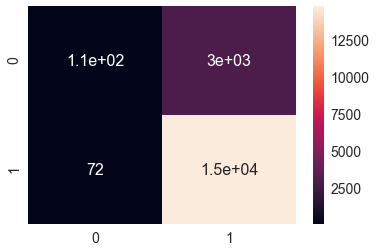

In [28]:
#plotting confusion matrix as heatmap
df_cm = pd.DataFrame(cm, range(2),range(2))
sn.set(font_scale=1.4) #for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}) #font size

## TF-IDF

### Simple Cross Validation(brute)

In [29]:
#applying fit transform on train datasset
tf_idf_vect = TfidfVectorizer(max_features=2000, min_df=50)
x_train_tfidf = tf_idf_vect.fit_transform(train_data['CleanedText'].values)
x_train_tfidf.shape

(42000, 2000)

In [30]:
#applying transform on test dataset
x_test_tfidf = tf_idf_vect.transform(test_data['CleanedText'].values)
x_test_tfidf.shape

(18000, 2000)

In [31]:
y_train_tfidf = train_data['Score']
y_test_tfidf = test_data['Score']

In [32]:
# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(x_train_tfidf, y_train_tfidf, test_size=0.3)

f1_scores=[]
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

for i in neighbors:
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i, algorithm='brute')

    # fitting the model on crossvalidation train
    knn.fit(X_tr, y_tr)

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv)
    
    #evaluate CV f1-score
    f1 = f1_score(y_cv, pred, pos_label='positive', average='binary')
    
    #printing f1-score of positive class for each k
    print('\nCV f1-score for k = %d is %f' % (i, f1))
    f1_scores.append(f1)
    

# determining optimal k
optimal_k = neighbors[f1_scores.index(max(f1_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

knn = KNeighborsClassifier(optimal_k)
knn.fit(X_tr,y_tr)
pred = knn.predict(x_test_tfidf)

#determining the Test f1 score for optimal k
f1 = f1_score(y_test_tfidf, pred, pos_label='positive', average='binary')
print('\n****Test f1-score for k = %d is %f****' % (optimal_k,f1))

#determining the Test accuracy for optimal k
acc = accuracy_score(y_test_tfidf, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = %d is %f%%****' % (optimal_k,acc))


CV f1-score for k = 1 is 0.913115

CV f1-score for k = 3 is 0.918770

CV f1-score for k = 5 is 0.922333

CV f1-score for k = 7 is 0.923303

CV f1-score for k = 9 is 0.923721

CV f1-score for k = 11 is 0.923727

CV f1-score for k = 13 is 0.924039

CV f1-score for k = 15 is 0.923840

CV f1-score for k = 17 is 0.923482

CV f1-score for k = 19 is 0.923495

CV f1-score for k = 21 is 0.923435

CV f1-score for k = 23 is 0.923534

CV f1-score for k = 25 is 0.923594

CV f1-score for k = 27 is 0.923382

CV f1-score for k = 29 is 0.923541

The optimal number of neighbors is 13.

****Test f1-score for k = 13 is 0.910450****

****Test accuracy for k = 13 is 83.822222%****


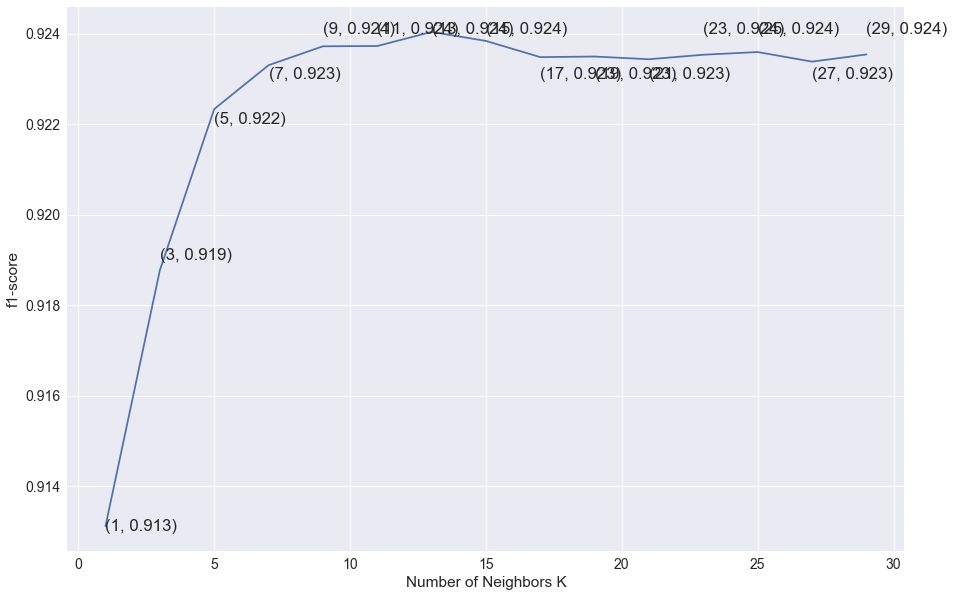

The f1-score for each k value is :  [0.91312 0.91877 0.92233 0.9233  0.92372 0.92373 0.92404 0.92384 0.92348
 0.92349 0.92344 0.92353 0.92359 0.92338 0.92354]


In [35]:
# plot f1-score vs k 
plt.figure(figsize=(15,10))
plt.plot(neighbors, f1_scores)
for xy in zip(neighbors, np.round(f1_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('f1-score')
plt.show()

print("The f1-score for each k value is : ", np.round(f1_scores,5))

### Simple Cross Validation (kd-tree)

In [9]:
#applying fit transform on train datasset
count_vect = CountVectorizer(max_features=2000, min_df=50)
x_train_tfidf_kd = count_vect.fit_transform(train_data_kd['CleanedText'].values)

#applying transform on test dataset
x_test_tfidf_kd = count_vect.transform(test_data_kd['CleanedText'].values)

#class labels for train & test datasets
y_train_tfidf_kd = train_data_kd['Score']
y_test_tfidf_kd = test_data_kd['Score']

In [10]:
# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(x_train_tfidf_kd.toarray(), y_train_tfidf_kd, test_size=0.3)

f1_scores=[]
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

for i in neighbors:
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')

    # fitting the model on crossvalidation train
    knn.fit(X_tr, y_tr)

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv)
    
    #evaluate CV f1-score
    f1 = f1_score(y_cv, pred, pos_label='positive', average='binary')
    
    #printing f1-score of positive class for each k
    print('\nCV f1-score for k = %d is %f' % (i, f1))
    f1_scores.append(f1)

# determining optimal k
optimal_k = neighbors[f1_scores.index(max(f1_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

knn = KNeighborsClassifier(optimal_k)
knn.fit(X_tr,y_tr)
pred = knn.predict(x_test_tfidf_kd.toarray())
#determining the Test f1 score for optimal k
f1 = f1_score(y_test_tfidf_kd, pred, pos_label='positive', average='binary')
print('\n****Test f1-score for k = %d is %f****' % (optimal_k,f1))
#determining the Test accuracy for optimal k
acc = accuracy_score(y_test_tfidf_kd, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = %d is %f%%****' % (optimal_k,acc))


CV f1-score for k = 1 is 0.917127

CV f1-score for k = 3 is 0.940367

CV f1-score for k = 5 is 0.943024

CV f1-score for k = 7 is 0.944683

CV f1-score for k = 9 is 0.943253

CV f1-score for k = 11 is 0.944318

CV f1-score for k = 13 is 0.943815

CV f1-score for k = 15 is 0.944640

CV f1-score for k = 17 is 0.944109

CV f1-score for k = 19 is 0.943634

CV f1-score for k = 21 is 0.944403

CV f1-score for k = 23 is 0.944403

CV f1-score for k = 25 is 0.944165

CV f1-score for k = 27 is 0.943928

CV f1-score for k = 29 is 0.943928

The optimal number of neighbors is 7.

****Test f1-score for k = 7 is 0.933929****

****Test accuracy for k = 7 is 87.666667%****


### Confusion Matrix

In [33]:
#computing confusion matrix
cm = confusion_matrix(y_test_tfidf, pred)
print(cm)

[[  285  2862]
 [   50 14803]]


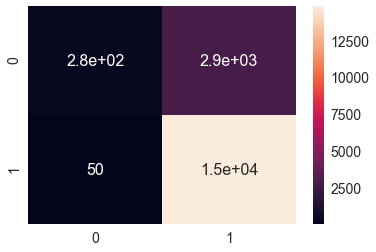

In [34]:
#plotting confusion matrix as heatmap
df_cm = pd.DataFrame(cm, range(2),range(2))
sn.set(font_scale=1.4) #for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}) #font size

## Avg Word2Vec

### Simple Cross Validation (brute)

In [51]:
#training Word2Vec Model for train dataset
i=0
list_of_sent=[]
for sent in train_data['CleanedText'].values:
    list_of_sent.append(sent.split())

In [37]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [38]:
X = w2v_model[w2v_model.wv.vocab]

C:\Users\Aziz\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [39]:
#computing Avg Word2Vec for train dataset
w2v_words = list(w2v_model.wv.vocab)
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████| 42000/42000 [03:32<00:00, 197.75it/s]


42000
50


In [40]:
x_train_w2v = np.array(sent_vectors)
y_train_w2v = train_data['Score']
x_train_w2v.shape

(42000, 50)

In [56]:
#training Word2Vec Model for test dataset
i=0
list_of_sent=[]
for sent in test_data['CleanedText'].values:
    list_of_sent.append(sent.split())

In [42]:
#computing Avg Word2Vec for test dataset
w2v_words = list(w2v_model.wv.vocab)
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████| 18000/18000 [01:51<00:00, 161.90it/s]


18000
50


In [43]:
x_test_w2v = np.array(sent_vectors)
y_test_w2v = test_data['Score']
x_test_w2v.shape

(18000, 50)

In [44]:
# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(x_train_w2v, y_train_w2v, test_size=0.3)

f1_scores=[]
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

for i in neighbors:
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i, algorithm='brute')

    # fitting the model on crossvalidation train
    knn.fit(X_tr, y_tr)

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv)
    
    #evaluate CV f1-score
    f1 = f1_score(y_cv, pred, pos_label='positive', average='binary')
    
    #printing f1-score of positive class for each k
    print('\nCV f1-score for k = %d is %f' % (i, f1))
    f1_scores.append(f1)
    

# determining optimal k
optimal_k = neighbors[f1_scores.index(max(f1_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

knn = KNeighborsClassifier(optimal_k)
knn.fit(X_tr,y_tr)
pred = knn.predict(x_test_w2v)

#determining the Test f1 score for optimal k
f1 = f1_score(y_test_w2v, pred, pos_label='positive', average='binary')
print('\n****Test f1-score for k = %d is %f****' % (optimal_k,f1))

#determining the Test accuracy for optimal k
acc = accuracy_score(y_test_w2v, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = %d is %f%%****' % (optimal_k,acc))


CV f1-score for k = 1 is 0.904874

CV f1-score for k = 3 is 0.922530

CV f1-score for k = 5 is 0.928206

CV f1-score for k = 7 is 0.930175

CV f1-score for k = 9 is 0.931214

CV f1-score for k = 11 is 0.931748

CV f1-score for k = 13 is 0.931580

CV f1-score for k = 15 is 0.932022

CV f1-score for k = 17 is 0.932363

CV f1-score for k = 19 is 0.932241

CV f1-score for k = 21 is 0.932242

CV f1-score for k = 23 is 0.932068

CV f1-score for k = 25 is 0.931636

CV f1-score for k = 27 is 0.930940

CV f1-score for k = 29 is 0.931244

The optimal number of neighbors is 17.

****Test f1-score for k = 17 is 0.919124****

****Test accuracy for k = 17 is 85.677778%****


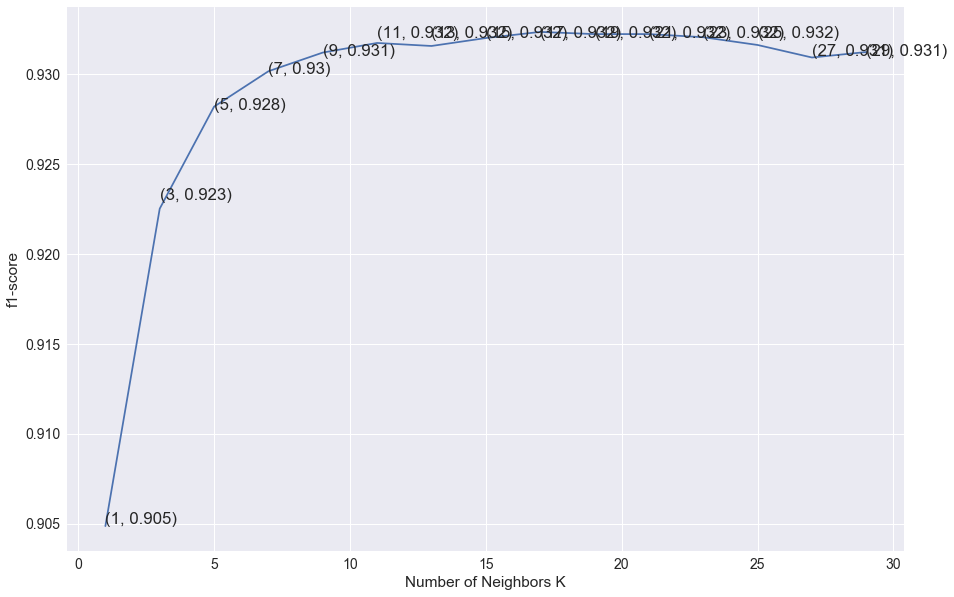

The f1-score for each k value is :  [0.90487 0.92253 0.92821 0.93017 0.93121 0.93175 0.93158 0.93202 0.93236
 0.93224 0.93224 0.93207 0.93164 0.93094 0.93124]


In [45]:
# plot f1-score vs k 
plt.figure(figsize=(15,10))
plt.plot(neighbors, f1_scores)
for xy in zip(neighbors, np.round(f1_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('f1-score')
plt.show()

print("The f1-score for each k value is : ", np.round(f1_scores,5))

### Simple Cross Validation (kd-tree)

In [22]:
#training Word2Vec Model for train dataset
i=0
list_of_sent=[]
for sent in train_data_kd['CleanedText'].values:
    list_of_sent.append(sent.split())

In [12]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
X = w2v_model[w2v_model.wv.vocab]

C:\Users\Aziz\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [13]:
#computing Avg Word2Vec for train dataset
w2v_words = list(w2v_model.wv.vocab)
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████| 7000/7000 [00:25<00:00, 271.90it/s]


7000
50


In [14]:
x_train_w2v_kd = np.array(sent_vectors)
y_train_w2v_kd = train_data_kd['Score']
x_train_w2v_kd.shape

(7000, 50)

In [25]:
#training Word2Vec Model for test dataset
i=0
list_of_sent=[]
for sent in test_data_kd['CleanedText'].values:
    list_of_sent.append(sent.split())

In [16]:
#computing Avg Word2Vec for test dataset
w2v_words = list(w2v_model.wv.vocab)
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████| 3000/3000 [00:12<00:00, 239.76it/s]


3000
50


In [17]:
x_test_w2v_kd = np.array(sent_vectors)
y_test_w2v_kd = test_data_kd['Score']
x_test_w2v_kd.shape

(3000, 50)

In [19]:
# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(x_train_w2v_kd, y_train_w2v_kd, test_size=0.3)

f1_scores=[]
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

for i in neighbors:
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')

    # fitting the model on crossvalidation train
    knn.fit(X_tr, y_tr)

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv)
    
    #evaluate CV f1-score
    f1 = f1_score(y_cv, pred, pos_label='positive', average='binary')
    
    #printing f1-score of positive class for each k
    print('\nCV f1-score for k = %d is %f' % (i, f1))
    f1_scores.append(f1)
    

# determining optimal k
optimal_k = neighbors[f1_scores.index(max(f1_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

knn = KNeighborsClassifier(optimal_k)
knn.fit(X_tr,y_tr)
pred = knn.predict(x_test_w2v_kd)

#determining the Test f1 score for optimal k
f1 = f1_score(y_test_w2v_kd, pred, pos_label='positive', average='binary')
print('\n****Test f1-score for k = %d is %f****' % (optimal_k,f1))

#determining the Test accuracy for optimal k
acc = accuracy_score(y_test_w2v_kd, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = %d is %f%%****' % (optimal_k,acc))


CV f1-score for k = 1 is 0.897422

CV f1-score for k = 3 is 0.922638

CV f1-score for k = 5 is 0.931556

CV f1-score for k = 7 is 0.935813

CV f1-score for k = 9 is 0.937595

CV f1-score for k = 11 is 0.938228

CV f1-score for k = 13 is 0.939302

CV f1-score for k = 15 is 0.939601

CV f1-score for k = 17 is 0.939869

CV f1-score for k = 19 is 0.939601

CV f1-score for k = 21 is 0.940136

CV f1-score for k = 23 is 0.940404

CV f1-score for k = 25 is 0.940909

CV f1-score for k = 27 is 0.940909

CV f1-score for k = 29 is 0.940909

The optimal number of neighbors is 25.

****Test f1-score for k = 25 is 0.935535****

****Test accuracy for k = 25 is 87.900000%****


### Confusion Matrix

In [46]:
#computing confusion matrix
cm = confusion_matrix(y_test_w2v, pred)
print(cm)

[[  773  2374]
 [  204 14649]]


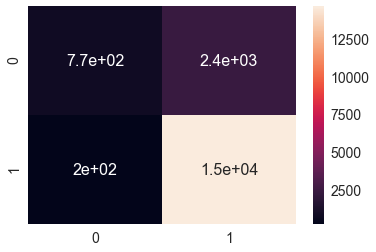

In [47]:
#plotting confusion matrix as heatmap
df_cm = pd.DataFrame(cm, range(2),range(2))
sn.set(font_scale=1.4) #for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}) #font size

## TF-IDF Word2Vec

### Simple Cross Validation (brute)

In [52]:
# training model for train dataset
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(train_data['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [53]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|███████████████████████████████████| 42000/42000 [04:31<00:00, 154.46it/s]


In [54]:
x_train_tfw2v = np.array(tfidf_sent_vectors)
y_train_tfw2v = train_data['Score']
x_train_tfw2v.shape

(42000, 50)

In [55]:
# training model for test dataset
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(test_data['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [57]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|███████████████████████████████████| 18000/18000 [02:00<00:00, 149.97it/s]


In [58]:
x_test_tfw2v = np.array(tfidf_sent_vectors)
y_test_tfw2v = test_data['Score']
x_test_tfw2v.shape

(18000, 50)

In [59]:
# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(x_train_tfw2v, y_train_tfw2v, test_size=0.3)

f1_scores=[]
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

for i in neighbors:
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i, algorithm='brute')

    # fitting the model on crossvalidation train
    knn.fit(X_tr, y_tr)

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv)
    
    #evaluate CV f1-score
    f1 = f1_score(y_cv, pred, pos_label='positive', average='binary')
    
    #printing f1-score of positive class for each k
    print('\nCV f1-score for k = %d is %f' % (i, f1))
    f1_scores.append(f1)
    

# determining optimal k
optimal_k = neighbors[f1_scores.index(max(f1_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

knn = KNeighborsClassifier(optimal_k)
knn.fit(X_tr,y_tr)
pred = knn.predict(x_test_tfw2v)

#determining the Test f1 score for optimal k
f1 = f1_score(y_test_tfw2v, pred, pos_label='positive', average='binary')
print('\n****Test f1-score for k = %d is %f****' % (optimal_k,f1))

#determining the Test accuracy for optimal k
acc = accuracy_score(y_test_tfw2v, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = %d is %f%%****' % (optimal_k,acc))


CV f1-score for k = 1 is 0.895784

CV f1-score for k = 3 is 0.917117

CV f1-score for k = 5 is 0.922605

CV f1-score for k = 7 is 0.925572

CV f1-score for k = 9 is 0.927377

CV f1-score for k = 11 is 0.928361

CV f1-score for k = 13 is 0.928518

CV f1-score for k = 15 is 0.928443

CV f1-score for k = 17 is 0.928312

CV f1-score for k = 19 is 0.928113

CV f1-score for k = 21 is 0.927907

CV f1-score for k = 23 is 0.927615

CV f1-score for k = 25 is 0.927612

CV f1-score for k = 27 is 0.927743

CV f1-score for k = 29 is 0.927834

The optimal number of neighbors is 13.

****Test f1-score for k = 13 is 0.913751****

****Test accuracy for k = 13 is 84.688889%****


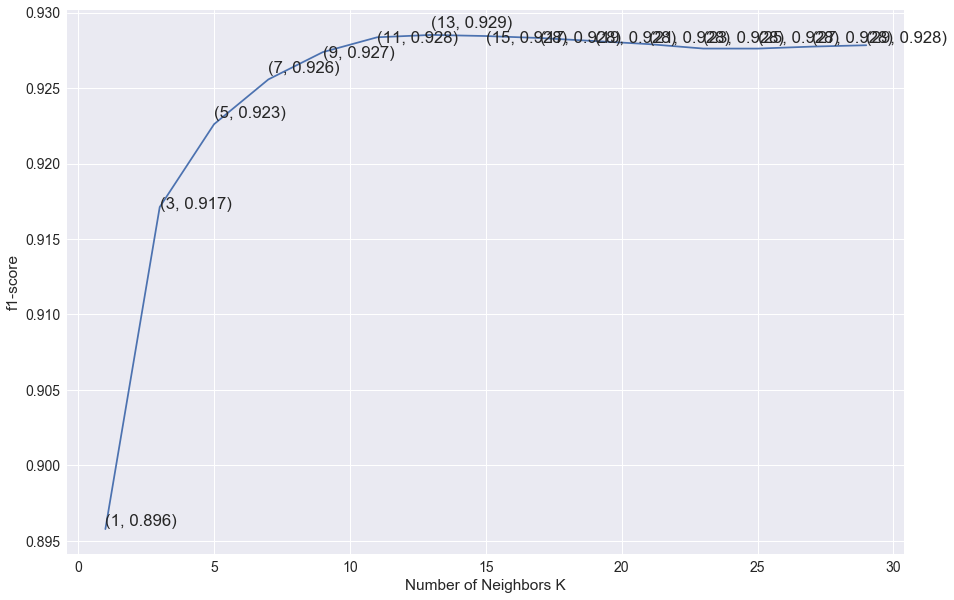

The f1-score for each k value is :  [0.89578 0.91712 0.9226  0.92557 0.92738 0.92836 0.92852 0.92844 0.92831
 0.92811 0.92791 0.92761 0.92761 0.92774 0.92783]


In [60]:
# plot f1-score vs k 
plt.figure(figsize=(15,10))
plt.plot(neighbors, f1_scores)
for xy in zip(neighbors, np.round(f1_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('f1-score')
plt.show()

print("The f1-score for each k value is : ", np.round(f1_scores,5))

### Simple Cross Validation (kd-tree)

In [20]:
# training model for train dataset
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(train_data_kd['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [23]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████| 7000/7000 [00:34<00:00, 202.16it/s]


In [24]:
x_train_tfw2v_kd = np.array(tfidf_sent_vectors)
y_train_tfw2v_kd = train_data_kd['Score']
x_train_tfw2v_kd.shape

(7000, 50)

In [26]:
# training model for test dataset
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(test_data_kd['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [27]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████| 3000/3000 [00:15<00:00, 189.16it/s]


In [28]:
x_test_tfw2v_kd = np.array(tfidf_sent_vectors)
y_test_tfw2v_kd = test_data_kd['Score']
x_test_tfw2v_kd.shape

(3000, 50)

In [29]:
# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(x_train_tfw2v_kd, y_train_tfw2v_kd, test_size=0.3)

f1_scores=[]
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

for i in neighbors:
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')

    # fitting the model on crossvalidation train
    knn.fit(X_tr, y_tr)

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv)
    
    #evaluate CV f1-score
    f1 = f1_score(y_cv, pred, pos_label='positive', average='binary')
    
    #printing f1-score of positive class for each k
    print('\nCV f1-score for k = %d is %f' % (i, f1))
    f1_scores.append(f1)

# determining optimal k
optimal_k = neighbors[f1_scores.index(max(f1_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

knn = KNeighborsClassifier(optimal_k)
knn.fit(X_tr,y_tr)
pred = knn.predict(x_test_tfw2v_kd)
#determining the Test f1 score for optimal k
f1 = f1_score(y_test_tfw2v_kd, pred, pos_label='positive', average='binary')
print('\n****Test f1-score for k = %d is %f****' % (optimal_k,f1))
#determining the Test accuracy for optimal k
acc = accuracy_score(y_test_tfw2v_kd, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = %d is %f%%****' % (optimal_k,acc))


CV f1-score for k = 1 is 0.891775

CV f1-score for k = 3 is 0.921319

CV f1-score for k = 5 is 0.934594

CV f1-score for k = 7 is 0.937611

CV f1-score for k = 9 is 0.938579

CV f1-score for k = 11 is 0.938403

CV f1-score for k = 13 is 0.938734

CV f1-score for k = 15 is 0.939034

CV f1-score for k = 17 is 0.938528

CV f1-score for k = 19 is 0.938528

CV f1-score for k = 21 is 0.938796

CV f1-score for k = 23 is 0.938796

CV f1-score for k = 25 is 0.938322

CV f1-score for k = 27 is 0.938322

CV f1-score for k = 29 is 0.938322

The optimal number of neighbors is 15.

****Test f1-score for k = 15 is 0.935724****

****Test accuracy for k = 15 is 87.933333%****


### Confusion Matrix

In [61]:
#computing confusion matrix
cm = confusion_matrix(y_test_w2v, pred)
print(cm)

[[  645  2502]
 [  254 14599]]


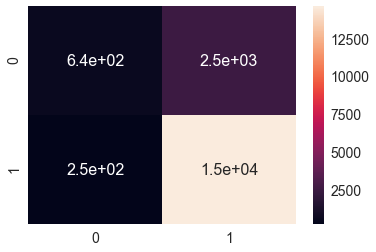

In [62]:
#plotting confusion matrix as heatmap
df_cm = pd.DataFrame(cm, range(2),range(2))
sn.set(font_scale=1.4) #for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}) #font size

## Conclusion

In [33]:
x=PrettyTable()
x.field_names = ['Vectorizer','Model','optimal k','f1-score','accuracy']
x.add_row(['BoW','Brute','9','0.904950','82.75%'])
x.add_row(['Tfidf','Brute','13','0.910450','83.82%'])
x.add_row(['Avg Word2Vec','Brute','17','0.91912','85.67%'])
x.add_row(['Tfidf-W2V','Brute','13','0.91375','84.68%'])
x.add_row(['BoW','Kd-Tree','13','0.936420','88.10%'])
x.add_row(['Tfidf','Kd-Tree','7','0.93392','83.66%'])
x.add_row(['Avg Word2Vec','Kd-Tree','25','0.93553','87.90%'])
x.add_row(['Tfidf-W2V','Kd-Tree','15','0.93572','87.93%'])
print(x)

+--------------+---------+-----------+----------+----------+
|  Vectorizer  |  Model  | optimal k | f1-score | accuracy |
+--------------+---------+-----------+----------+----------+
|     BoW      |  Brute  |     9     | 0.904950 |  82.75%  |
|    Tfidf     |  Brute  |     13    | 0.910450 |  83.82%  |
| Avg Word2Vec |  Brute  |     17    | 0.91912  |  85.67%  |
|  Tfidf-W2V   |  Brute  |     13    | 0.91375  |  84.68%  |
|     BoW      | Kd-Tree |     13    | 0.936420 |  88.10%  |
|    Tfidf     | Kd-Tree |     7     | 0.93392  |  83.66%  |
| Avg Word2Vec | Kd-Tree |     25    | 0.93553  |  87.90%  |
|  Tfidf-W2V   | Kd-Tree |     15    | 0.93572  |  87.93%  |
+--------------+---------+-----------+----------+----------+


From the above table, we conclude:-
1. For Brute Force implementation, Avg Word2Vec gives the largest value of f1-score(0.919) as well as the highest accuracy(85.67). 
2. For Kd-Tree implementation, BoW gives the largest value of f1-score(0.936) as well as the highest accuracy(88.10).
3. Therefore, Kd-Tree implementation of KNN is more efficient as compared to Brute Force implementation for all featurization methods.